In [1]:
import cirq
import numpy as np

import cirq_qubitization as cq

from cirq_qubitization.cirq_algos.qubitization_walk_operator_test import get_walk_operator_for_1d_ising_model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Implements Heisenberg-Limited Phase Estimation of the Qubitized Quantum Walks as described in Section-II B. of [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662)



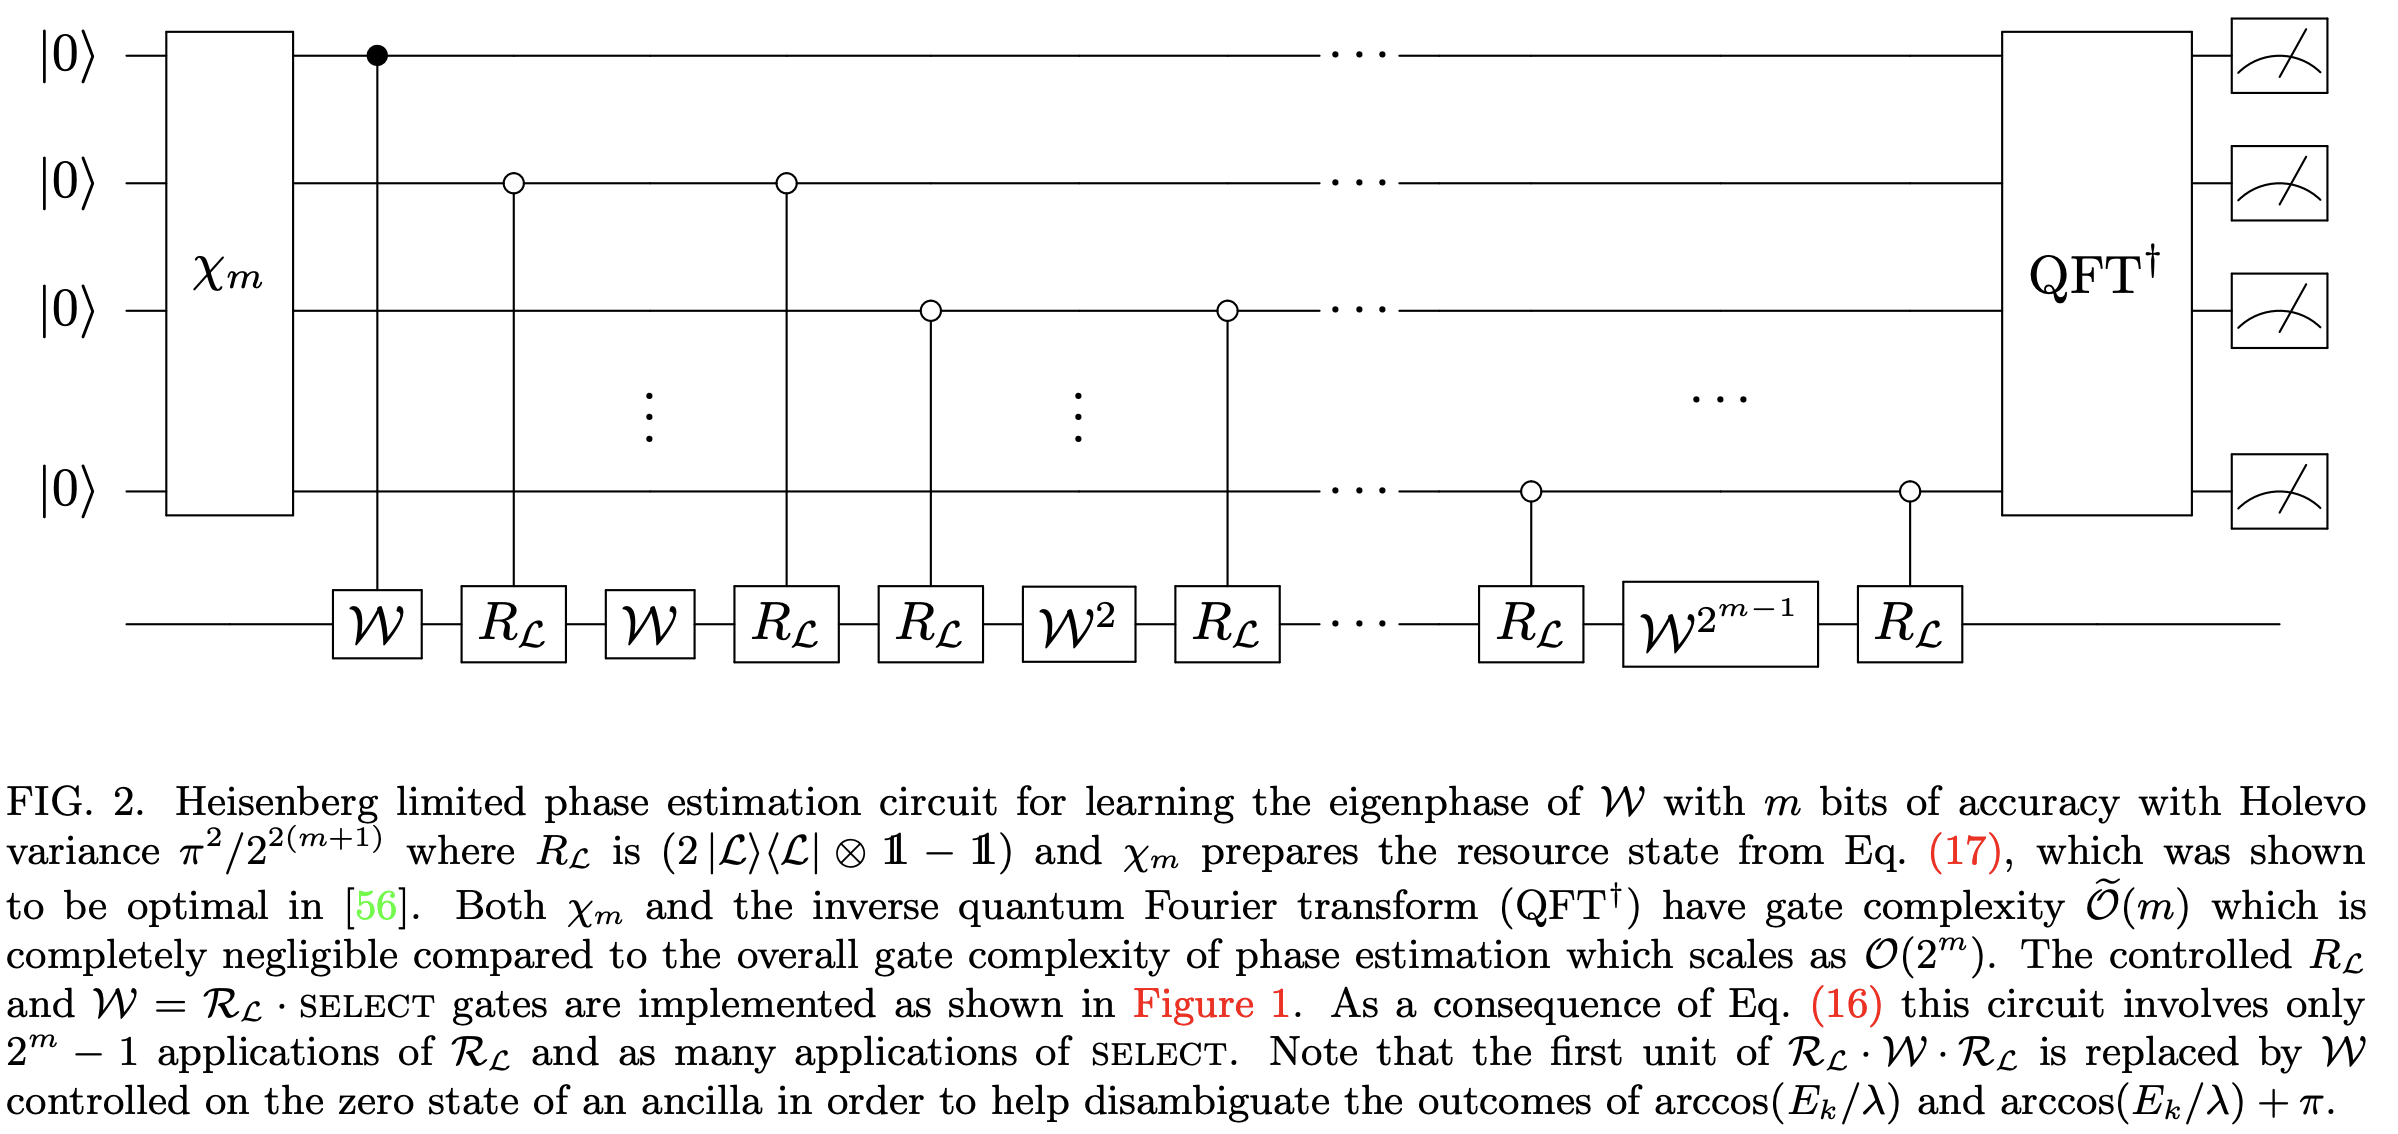

In [7]:
def get_resource_state(m: int):
    den = 1 + 2 ** m
    norm = np.sqrt(2 / den)
    return norm * np.sin(np.pi * (1 + np.arange(2**m)) / den)        
    
def phase_estimation(walk: cq.QubitizationWalkOperator, m: int) -> cirq.OP_TREE:
    reflect = walk._reflect
    walk_regs = walk.registers.get_named_qubits()
    reflect_regs = {k:v for k, v in walk_regs.items() if k in reflect.registers}
    
    reflect_controlled = reflect.controlled(control_values=[0])
    walk_controlled = walk.controlled(control_values=[1])
    reflect_op = reflect.on_registers(**reflect_regs)

    m_qubits = [cirq.q(f'm_{i}') for i in range(m)]
    state_prep = cirq.StatePreparationChannel(get_resource_state(m), name='𝜒_m')

    yield state_prep.on(*m_qubits)
    yield walk_controlled.on_registers(**walk_regs, control=m_qubits[0])
    for i in range(1, m):
        yield reflect_controlled.on_registers(control=m_qubits[i], **reflect_regs)
        yield walk.on_registers(**walk_regs)
        walk = walk ** 2
        yield reflect_controlled.on_registers(control=m_qubits[i], **reflect_regs)
        
    yield cirq.qft(*m_qubits, inverse=True)

In [6]:
num_sites: int = 6
eps: float = 1e-2
m_bits: int = 4

circuit = cirq.Circuit(phase_estimation(get_walk_operator_for_1d_ising_model(num_sites, eps), m=m_bits))
print(circuit)

m_0: ──────────𝜒_m[1]───@─────────────────────────────────────────────────────────────qft^-1───
               │        │                                                             │
m_1: ──────────𝜒_m[2]───┼───@(0)───────@(0)───────────────────────────────────────────#2───────
               │        │   │          │                                              │
m_2: ──────────𝜒_m[3]───┼───┼──────────┼──────@(0)─────────@(0)───────────────────────#3───────
               │        │   │          │      │            │                          │
m_3: ──────────𝜒_m[4]───┼───┼──────────┼──────┼────────────┼──────@(0)─────────@(0)───#4───────
                        │   │          │      │            │      │            │
selection0: ────────────W───R_L────W───R_L────R_L────W─────R_L────R_L────W─────R_L─────────────
                        │   │      │   │      │      │     │      │      │     │
selection1: ────────────W───R_L────W───R_L────R_L────W─────R_L────R_L────W─────R_L────────────

In [3]:
num_sites: int = 200
eps: float = 1e-5
m_bits: int = 14

circuit = cirq.Circuit(phase_estimation(get_walk_operator_for_1d_ising_model(num_sites, eps), m=m_bits))
%time cq.t_complexity(circuit[2:-1])

CPU times: user 1.63 s, sys: 17.9 ms, total: 1.65 s
Wall time: 1.17 s


TComplexity(t=47239226, clifford=213171836, rotations=2432232)